## Notebook EDA

## ML Challenge #23 

In [1]:
import json
import pandas as pd

import pandas as pd
train_df = pd.read_json ("data/train.json")
train_df.head()

test_df = pd.read_json ("data/test.json")
test_df.head()

,paperId,title,abstract,year,venue
0,86e1aaa0c47659e08a896e9889384eb1e5401e6a,Exploring the Linear Subspace Hypothesis in Ge...,Bolukbasi et al. (2016) presents one of the fi...,2020,EMNLP
1,8d3076c38f56df22052567f4783c670d8e860f09,HyKnow: End-to-End Task-Oriented Dialog Modeli...,Task-oriented dialog (TOD) systems typically m...,2021,FINDINGS
2,7c400ee676d427eeda1aad5c1c54c316f0b9773d,A Multilingual Information Extraction Pipeline...,We introduce an advanced information extractio...,2018,EMNLP
3,185e7d2a761594451b02ace240356dadad2aef78,Dice Loss for Data-imbalanced NLP Tasks,Many NLP tasks such as tagging and machine rea...,2019,ACL
4,e4363d077a890c8d5c5e66b82fe69a1bbbdd5c80,Attention Guided Graph Convolutional Networks ...,Dependency trees convey rich structural inform...,2019,ACL


Check for missing values

In [2]:
train_df.isna().any().any()

False

Data info (types)

In [3]:
train_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12129 entries, 0 to 12128
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   paperId     12129 non-null  object
 1   title       12129 non-null  object
 2   authorId    12129 non-null  int64 
 3   authorName  12129 non-null  object
 4   abstract    12129 non-null  object
 5   year        12129 non-null  int64 
 6   venue       12129 non-null  object
dtypes: int64(2), object(5)
memory usage: 663.4+ KB


No empty columms, 7 columns, 12129 rows, types of the variables are seen in Dtype.
POI: Year and AuthorID are loaded as int64, instead of objects.


Check feature stats

In [6]:
# check how many unique authers 
sum(train_df["authorId"].value_counts() == 1)


2207

In [7]:
train_df["venue"].value_counts()

ACL                                                                          2860
EMNLP                                                                        2247
NAACL                                                                        1023
*SEMEVAL                                                                      470
FINDINGS                                                                      399
                                                                             ... 
DLG4NLP                                                                         1
SCAI                                                                            1
ACL 2020                                                                        1
bioRxiv                                                                         1
Proceedings of the Workshop on Generalization in the Age of Deep Learning       1
Name: venue, Length: 362, dtype: int64

In [8]:
train_df["year"].value_counts().head(8)


2019    1845
2021    1839
2020    1723
2018    1361
2016    1014
2017    1000
2015     901
2014     800
Name: year, dtype: int64

Unique Rows

In [9]:
len(train_df.authorId.unique())


5625

In [10]:
len(train_df.title.unique())

12120

In [11]:
len(train_df.abstract.unique())

12124

Number of unique paperId is equal to rows, paperId is main key.

## Check for correlations

In [12]:
from dython.nominal import associations

df = train_df.apply(
    lambda x: x.astype("object") if x.dtype == "int64" else x)
df = df[[i for i in df.columns if i in ('authorId','year','venue')]]


df.head(15)

,authorId,year,venue
0,3188285,2014,CLPsych@ACL
1,2782720,2018,Fig-Lang@NAACL-HLT
2,144748442,2021,ACL
3,46331602,2022,ACL
4,30887404,2019,FINDINGS
5,46649145,2019,EMNLP
6,2390150,1995,ACL
7,151474408,2021,EMNLP
8,1696542,2014,WMT@ACL
9,144518416,2017,Rep4NLP@ACL


In [13]:
from sklearn import preprocessing

label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame() 

for i in df.columns :
  data_encoded[i]=label.fit_transform(df[i])

data_encoded.head()  

,authorId,year,venue
0,1571,35,58
1,1250,39,122
2,4134,42,5
3,3038,43,5
4,2444,40,119


In [14]:
from scipy.stats import chi2_contingency
import numpy as np


def cramers_V(var1,var2) :
  """
  Calculates Cramers_V

  source: = https://www.kaggle.com/code/adrianrolla/logistic-regression
  """
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = np.min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

rows= []

for var1 in data_encoded:
  col = []
  for var2 in data_encoded :
    cramers =cramers_V(data_encoded[var1], data_encoded[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df2 = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)

df2

,authorId,year,venue
authorId,1.00,0.48,0.51
year,0.48,1.00,0.10
venue,0.51,0.10,1.00


In [15]:
## number of characters in the text 
train_df["num_chars"] = train_df["abstract"].apply(lambda x: len(str(x)))



In [16]:
train_df = train_df.apply(
    lambda x: x.astype("object") if x.dtype == "int64" else x)

test_df = test_df.apply(
    lambda x: x.astype("object") if x.dtype == "int64" else x)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12129 entries, 0 to 12128
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   paperId     12129 non-null  object
 1   title       12129 non-null  object
 2   authorId    12129 non-null  object
 3   authorName  12129 non-null  object
 4   abstract    12129 non-null  object
 5   year        12129 non-null  object
 6   venue       12129 non-null  object
 7   num_chars   12129 non-null  object
dtypes: object(8)
memory usage: 758.2+ KB


In [17]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
eng_stopwords = set(stopwords.words("english"))
import string
from collections import Counter

### Feature Engineering #

## Number of words in the text ##
train_df["num_words"] = train_df["abstract"].apply(lambda x: round(len(str(x).split())/50)*50)

## Number of unique words in the text ##
train_df["num_unique_words"] = train_df["abstract"].apply(lambda x: round(len(set(str(x).split()))/50)*50)

## Number of characters in the text ##
train_df["num_chars"] = train_df["abstract"].apply(lambda x: round(len(str(x))/100)*100)

## Number of stopwords in the text ##
train_df["num_stopwords"] = train_df["abstract"].apply(lambda x: round(len([w for w in str(x).lower().split() if w in eng_stopwords])/10)*10)

## Number of punctuations in the text ##
train_df["num_punctuations"] =train_df['abstract'].apply(lambda x: round(len([c for c in str(x) if c in string.punctuation])/10)*10)

## Number of title case words in the text ##
train_df["num_words_upper"] = train_df["abstract"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train_df["num_words_title"] = train_df["abstract"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train_df["mean_word_len"] = train_df["abstract"].apply(lambda x: round(np.mean([len(w) for w in str(x).split()])/1)*1)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dprin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
train_df["abstract"]

0        Children with autism spectrum disorder often e...
1        We present and compare two alternative deep ne...
2        Visual Question Answering (VQA) methods aim at...
3        Coreference resolution over semantic graphs li...
4        In this paper, we present Linguistics Informed...
                               ...                        
12124    The de-facto standard decoding method for sema...
12125    This is a report on the methods used and resul...
12126    We describe the second IWPT task on end-to-end...
12127    Abstract This paper investigates the ability o...
12128    FrameNet is the best currently operational ver...
Name: abstract, Length: 12129, dtype: object

In [19]:
train_id = train_df['authorId'].values

### recompute the trauncated variables again ###
train_df["num_words"] = train_df["abstract"].apply(lambda x: round(len(str(x).split())/25)*25)
train_df["mean_word_len"] = train_df["abstract"].apply(lambda x: round(np.mean([len(w) for w in str(x).split()])/1)*1)

test_df["num_words"] = test_df["abstract"].apply(lambda x: round(len(str(x).split())/25)*25)
test_df["mean_word_len"] = test_df["abstract"].apply(lambda x: round(np.mean([len(w) for w in str(x).split()])/1)*1)



cols_to_drop = ['authorId', 'abstract']

C:\Users\dprin\AppData\Local\Temp\ipykernel_4108\2275619544.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['num_words'].loc[train_df['num_words']>300] = 300 #truncation for better visuals


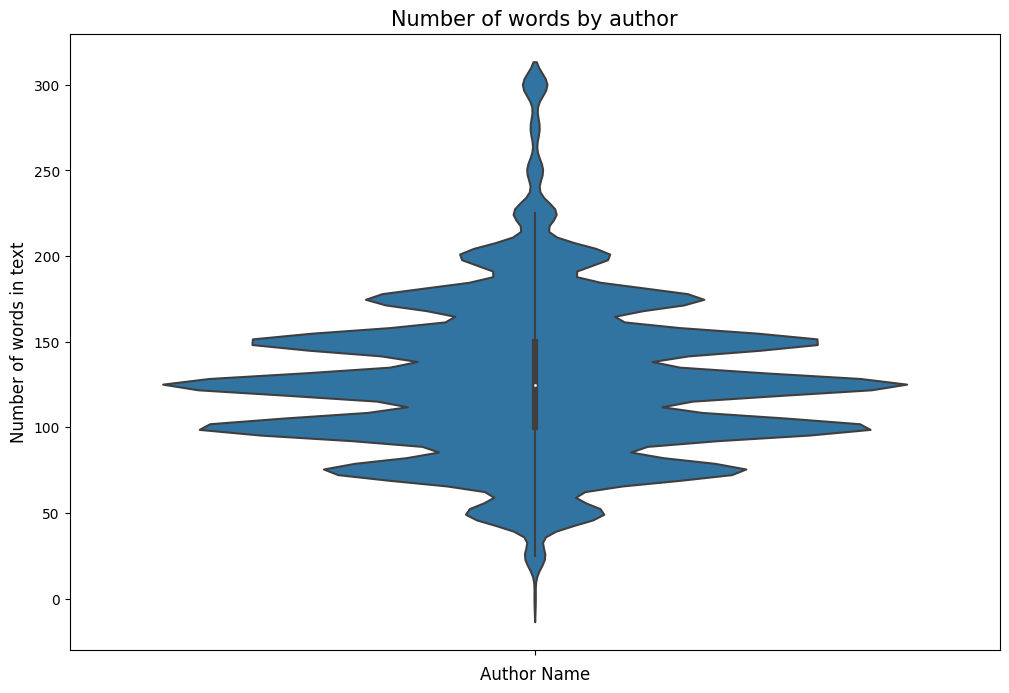

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

train_df['num_words'].loc[train_df['num_words']>300] = 300 #truncation for better visuals
plt.figure(figsize=(12,8))
sns.violinplot(y='num_words', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title("Number of words by author", fontsize=15)
plt.show()

In [22]:
import string
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

stopwords = set(stopwords.words("english"))
words = ("pp", "method", "paper", "task", "present")


train_df['abstractClean'] = train_df['abstract'].str.replace('[^[a-zA-Z0-9-]*$]',' ')
train_df['abstractClean'] = train_df['abstractClean'].str.lower()
train_df["abstractClean"] = train_df["abstractClean"].str.strip()
train_df["abstractClean"] = train_df["abstractClean"].str.split()  
train_df['abstractClean'] = train_df['abstractClean'].apply(lambda x: ' '.join([word for word in x if word not in stopwords]))


train_df['titleClean'] = train_df['title'].str.replace('[^[a-zA-Z0-9-]*$]',' ')
train_df['titleClean'] = train_df['titleClean'].str.lower()
train_df["titleClean"] = train_df["titleClean"].str.strip()
train_df["titleClean"] = train_df["titleClean"].str.split()
train_df['titleClean'] = train_df['titleClean'].apply(lambda x: ' '.join([word for word in x if word not in stopwords]))


train_df.head(5)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dprin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dprin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dprin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\dprin\AppData\Local\Temp\ipykernel_4108\1523786658.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  train_df['abstractClean'] = train_df['abstract'].str.replace('[^[a-zA-Z0-9-]*$]',' ')
C:\Users\dprin\AppData\Local\Temp\ipykernel_4108\1523786658.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  train_df['titleClean'] = train_df['title'].str.replace('[^[a-zA-Z0-9-]*$]',' ')


,paperId,title,authorId,authorName,abstract,year,venue,num_chars,num_words,num_unique_words,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len,abstractClean,titleClean
0,0b341b6938308a6d5f47edf490f6e46eae3835fa,Detecting linguistic idiosyncratic interests i...,3188285,Masoud Rouhizadeh,Children with autism spectrum disorder often e...,2014,CLPsych@ACL,900,150,100,60,10,0,5,6,children autism spectrum disorder often exhibi...,detecting linguistic idiosyncratic interests a...
1,c682727ee058aadbe9dbf838dcb036322818f588,Bigrams and BiLSTMs Two Neural Networks for Se...,2782720,Yuri Bizzoni,We present and compare two alternative deep ne...,2018,Fig-Lang@NAACL-HLT,400,50,50,20,10,0,2,6,present compare two alternative deep neural ar...,bigrams bilstms two neural networks sequential...
2,0f9b5b32229a7245e43754430c0c88f8e7f0d8af,In Factuality: Efficient Integration of Releva...,144748442,Peter Vickers,Visual Question Answering (VQA) methods aim at...,2021,ACL,700,100,100,30,20,3,8,6,visual question answering (vqa) methods aim le...,factuality: efficient integration relevant fac...
3,7e8b4cfdc03b59ece2d6b33a217f0abd47f708d9,Variational Graph Autoencoding as Cheap Superv...,46331602,Irene Li,Coreference resolution over semantic graphs li...,2022,ACL,800,125,100,40,20,7,8,6,coreference resolution semantic graphs like am...,variational graph autoencoding cheap supervisi...
4,07588dd5d0252c7abc99b3834a81bf23741ead4b,LIMIT-BERT : Linguistics Informed Multi-Task BERT,30887404,Junru Zhou,"In this paper, we present Linguistics Informed...",2019,FINDINGS,1300,175,100,50,40,14,18,6,"paper, present linguistics informed multi-task...",limit-bert : linguistics informed multi-task bert


In [24]:
# add lemmer
lemmer = nltk.WordNetLemmatizer()
train_df["abstractCleanLem"] = train_df["abstractClean"].str.split()  
train_df["abstractCleanLem"] = train_df["abstractCleanLem"].apply(lambda x: ' '.join([lemmer.lemmatize(word) for word in x]))

train_df["titleCleanLem"] = train_df["titleClean"].str.split()  
train_df["titleCleanLem"] = train_df["titleCleanLem"].apply(lambda x: ' '.join([lemmer.lemmatize(word) for word in x]))


train_df["abstractCleanLem"][1]

##train_df.to_csv("output.csv")

'present compare two alternative deep neural architecture perform word-level metaphor detection text: bi-lstm model new structure based recursive feed-forward concatenation input. discus different version model effect input manipulation - specifically, reducing length sentence introducing concreteness score word - performance.'

In [25]:
# add lemmer
lemmer = nltk.WordNetLemmatizer()
test_df["abstractCleanLem"] = test_df["abstractClean"].str.split()  
test_df["abstractCleanLem"] = test_df["abstractCleanLem"].apply(lambda x: ' '.join([lemmer.lemmatize(word) for word in x]))

test_df["titleCleanLem"] = test_df["titleClean"].str.split()  
test_df["titleCleanLem"] = test_df["titleCleanLem"].apply(lambda x: ' '.join([lemmer.lemmatize(word) for word in x]))

test_df["abstractCleanLem"][1]
##train_df.to_csv("output.csv")

'task-oriented dialog (tod) system typically manage structured knowledge (e.g. ontology and databases) to guide the goal-oriented conversations. however, they fall short of handling dialog turn grounded on unstructured knowledge (e.g. review and documents). in this paper, we formulate a task of modeling tod grounded on both structured and unstructured knowledge. to address this task, we propose a tod system with hybrid knowledge management, hyknow. it extends the belief state to manage both structured and unstructured knowledge, and is the first end-to-end model that jointly optimizes dialog modeling grounded on these two kind of knowledge. we conduct experiment on the modified version of multiwoz 2.1 dataset, where dialog are grounded on hybrid knowledge. experimental result show that hyknow ha strong end-to-end performance compared to existing tod systems. it also outperforms the pipeline knowledge management schemes, with higher unstructured knowledge retrieval accuracy.'

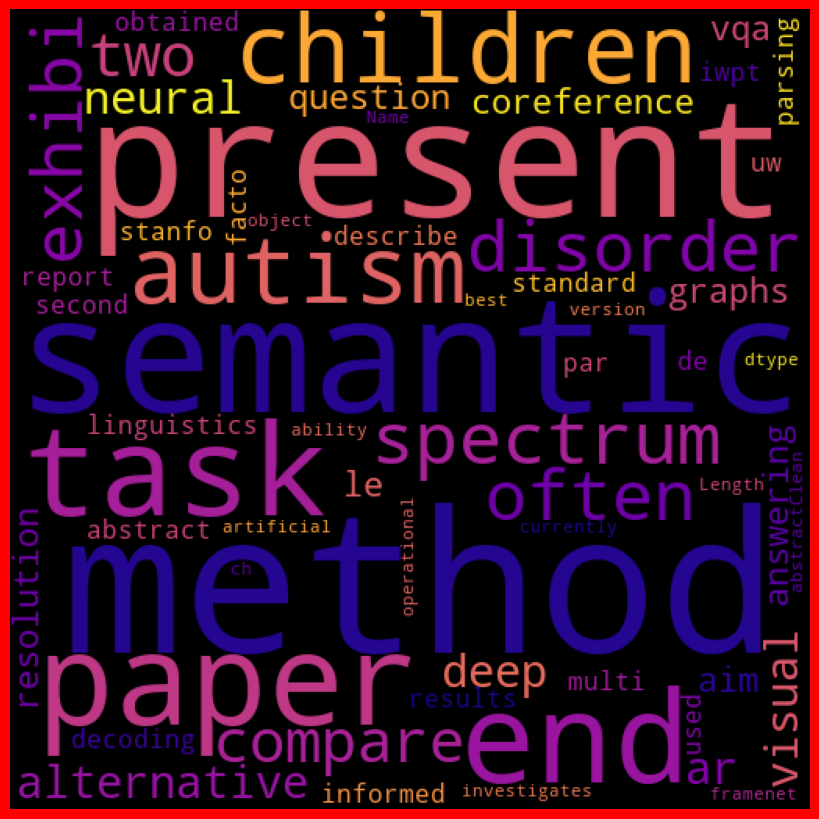

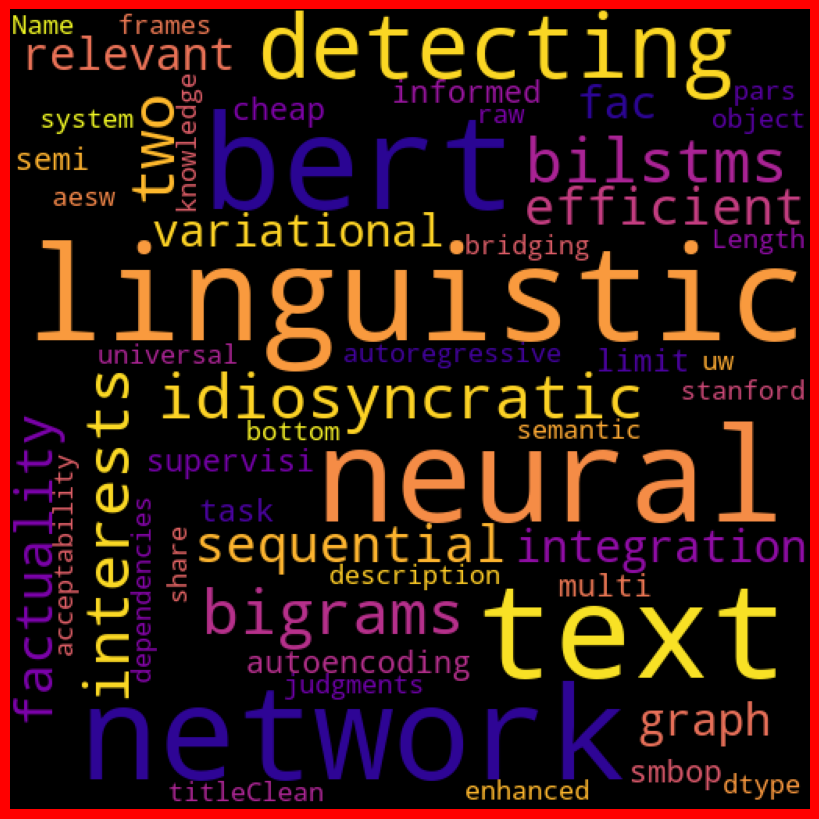

In [27]:
from wordcloud import WordCloud

train_wc = str(train_df["abstractClean"])
train_wc_title = str(train_df["titleClean"])

train_wc = WordCloud(width = 512, height = 512, colormap = 'plasma').generate(train_wc)
train_wc_title = WordCloud(width = 512, height = 512, colormap = 'plasma').generate(train_wc_title)



plt.figure(figsize = (10,8), facecolor = 'r')
plt.imshow(train_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

plt.figure(figsize = (10,8), facecolor = 'r')
plt.imshow(train_wc_title)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()



#

In [28]:

#Train test split
#train_df, validation_df = train_test_split(train_df, test_size=0.2)

#test_id = validation_df['authorId'].values

#train_X = train_df.drop(cols_to_drop+['authorName'], axis=1)
#validation_X = validation_df.drop(cols_to_drop, axis=1)

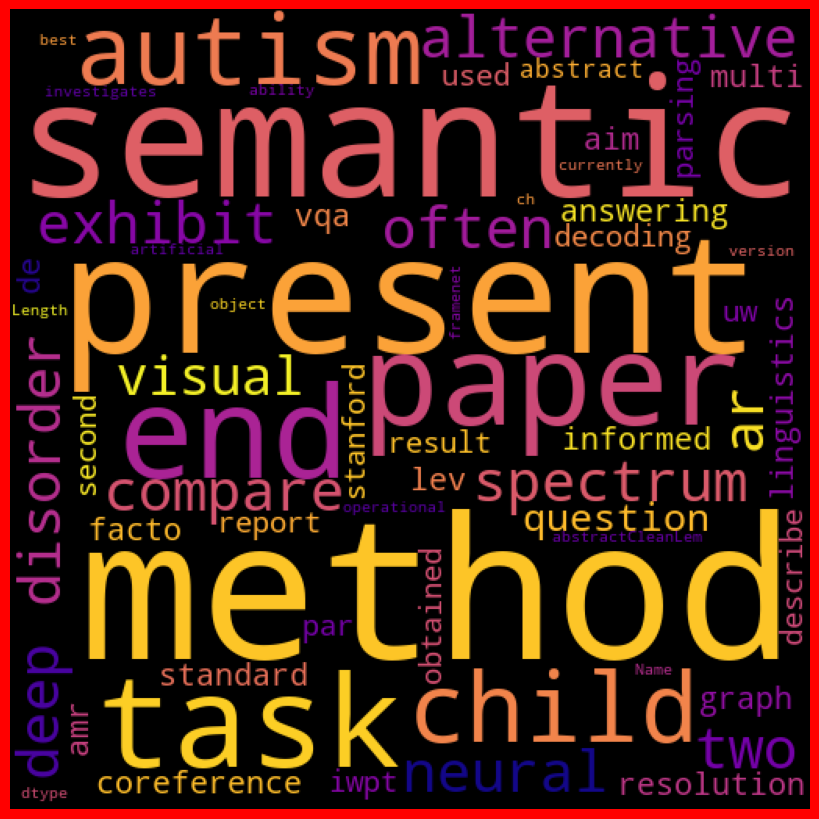

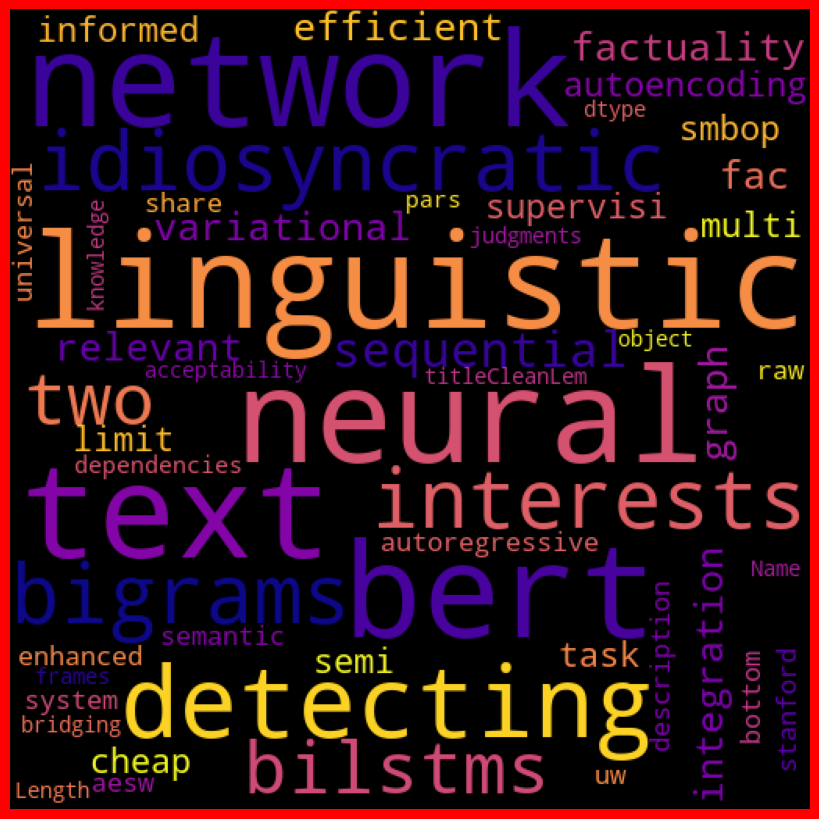

In [29]:
words = ()#"method", "paper", "task", "present", "aim", "end", "paper", "often", "text")
train_df["titleCleanLem"] = train_df["titleClean"].str.split()  
train_df['titleCleanLem'] = train_df['titleCleanLem'].apply(lambda x: ' '.join([word for word in x if word not in words]))

train_df["abstractCleanLem"] = train_df["abstractCleanLem"].str.split()  
train_df['abstractCleanLem'] = train_df['abstractCleanLem'].apply(lambda x: ' '.join([word for word in x if word not in words]))

from wordcloud import WordCloud

train_wc = str(train_df["abstractCleanLem"])
train_wc_title = str(train_df["titleCleanLem"])

train_wc = WordCloud(width = 512, height = 512, colormap = 'plasma').generate(train_wc)
train_wc_title = WordCloud(width = 512, height = 512, colormap = 'plasma').generate(train_wc_title)



plt.figure(figsize = (10,8), facecolor = 'r')
plt.imshow(train_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

plt.figure(figsize = (10,8), facecolor = 'r')
plt.imshow(train_wc_title)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()
